In [13]:
import spacy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

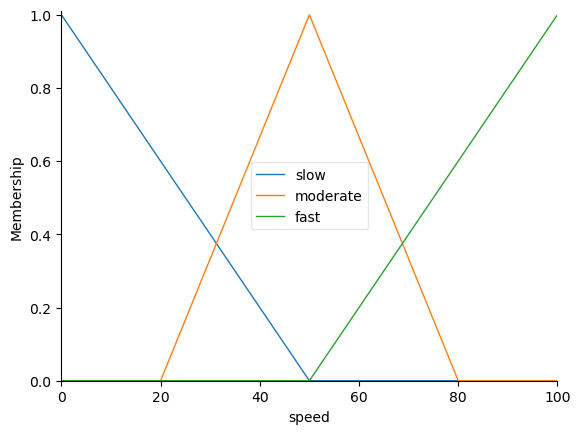

In [14]:
#Loading spaCy model for NLP
nlp = spacy.load('en_core_web_sm')

# Fuzzy variable description for speed
speed = ctrl.Antecedent(np.arange(0, 101, 1), 'speed')
speed['slow'] = fuzz.trimf(speed.universe, [0, 0, 50])
speed['moderate'] = fuzz.trimf(speed.universe, [20, 50, 80])
speed['fast'] = fuzz.trimf(speed.universe, [50, 100, 100])
speed.view()

In [15]:
def parse_natural_language_query(query):
    doc = nlp(query)
    subject, action, attribute, fuzzy_value = "", "", "", ""
    
    for token in doc:
        if token.dep_ == 'nsubj':
            subject = token.text
        elif token.dep_ == 'ROOT':
            action = token.text
        elif token.dep_ == 'attr':
            attribute = token.text
        elif token.pos_ == 'ADJ':
            fuzzy_value = token.text
    
    return subject, action, attribute, fuzzy_value



In [16]:
def map_fuzzy_value_to_set(fuzzy_value):
    if fuzzy_value == 'fast':
        return speed['fast']
    elif fuzzy_value == 'moderate':
        return speed['moderate']
    elif fuzzy_value == 'slow':
        return speed['slow']
    else:
        raise ValueError("Unknown fuzzy value")


#Generating the query based on the input and fuzzifying it
def generate_fuzzy_query(attribute, fuzzy_set):
    return f"SELECT object_id, {attribute} FROM player_data WHERE {attribute} IS ABOUT {fuzzy_set};"



In [17]:
def execute_fuzzy_query(fuzzy_query, fuzzy_set):
    player_data = [
        {"object_id": 1, "speed": 60},
        {"object_id": 2, "speed": 85},
        {"object_id": 3, "speed": 40},
    ]
    
    matching_results = []
    for data in player_data:
        speed_input = data["speed"]
        
        # Get QCI (Query Compatibility Index) by interpolating the membership
        qci = fuzz.interp_membership(speed.universe, fuzzy_set.mf, speed_input)
        
        if qci > 0:
            matching_results.append({"object_id": data["object_id"], "qci": qci})
    
    return sorted(matching_results, key=lambda x: x["qci"], reverse=True)



In [18]:
def display_results(results):
    print("Ranked Query Results:")
    for result in results:
        print(f"Object ID: {result['object_id']}, QCI: {result['qci']:.2f}")



In [30]:

query = "Find players moving at fast speed"
subject, action, attribute, fuzzy_value = parse_natural_language_query(query)
fuzzy_set = map_fuzzy_value_to_set(fuzzy_value)
fuzzy_query = generate_fuzzy_query(attribute, fuzzy_set)
results = execute_fuzzy_query(fuzzy_query, fuzzy_set)
display_results(results)


Ranked Query Results:
Object ID: 2, QCI: 0.70
Object ID: 1, QCI: 0.20
